In [1]:
import torch 
import torch.nn as nn
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

# Multilayer Perceptron

Let's start with the most simple neural network out there: the Multilayer Perceptron. This neural network model just consists on sequential multiple linear transformations with some activation functions in between. These activation functions are the ones that gave the non-linear properties to the model.

In [2]:
"""
Defining the dataset

In this case we are using the simple digits dataset, which consists on 8x8 gray scaled images of written numbers 0-9 in a very low r
"""
class DigitsDataset:
    def __init__(self):
        digits_data_ = load_digits()
        self.imgs = digits_data_.images.reshape((-1,1,8,8)) / 16.0
        self.target = digits_data_.target
    def __getitem__(self,idx):
        return torch.from_numpy(self.imgs[idx]).float(), self.target[idx]
    def __len__(self):
        return len(self.imgs)

In [3]:
# Creating the digits dataset object
digits_ds = DigitsDataset()

In [4]:
# Splitting the dataset into train and test dataset
N = len(digits_ds)
train_size = int(0.8*N)
test_size = N - train_size
train_ds, test_ds = torch.utils.data.random_split(digits_ds,[train_size, test_size])

In [5]:
# Creating the datataloaders
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=32)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=32)

In [6]:
# Creating a simple MLP
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(64,32),
    nn.ReLU(inplace=True),
    nn.Linear(32,10)
)
"""
To train the model we need to measure how well the model is doing with respect the dataset. 
To do so, we use a loss function proper for the task that is being handled.

In this case, the task is image classification and thus the most proper loss function is the Cross Entropy Loss
"""
crit = nn.CrossEntropyLoss()

"""
Once we calculate the loss and performa the backpropagation to calculate the gradient of the loss w.r.t. 
each parameter, we need a way to update the parameters using the gradient. This is called optimization. 
The simplest optimization method there is, it is the SGD. Which just follows the negative of the gradient scaled by
a factor called learning rate.
"""
optim = torch.optim.SGD(model.parameters(),lr=0.1)

In [7]:
# Training the model
for epoch in range(10):
    tot_loss = 0
    for x,y in train_dl:
        # Set the gradients of all parameters to zero 
        # Since the when we perform backpropagation, the gradients accumulates
        optim.zero_grad()
        # Forward the current input
        o = model(x)
        # Calculate the loss
        l = crit(o,y)
        tot_loss += l.item()
        # Backpropagate
        l.backward()
        # Update the parameters using the chosen optimizer
        optim.step()
    print(tot_loss/len(train_dl))

2.2143691486782497
1.8418954372406007
1.2355459716584947
0.7784636000792186
0.5452256381511689
0.42059323456552294
0.3455323312017653
0.2961128963364495
0.2613716446691089
0.23556177549892002


# Convolutional Neural Network

The operation of convolution helps to extract spatial features from the input data.

In [8]:
"""
Defining the model
The convolutional layers (along with the activation functions and pooling layers) are in charge of extract 
features from the input, while the last layer (linear) is in charge of classify those features into the 
available classes
"""
model = nn.Sequential(
    nn.Conv2d(1,16,3,padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(16,32,3,padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(32,32,3,padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(32,10)
)
# Since this is still a classfication problem we are using Cross Entropy Loss as our loss function
crit = nn.CrossEntropyLoss()
# We are also still using the SGD optimizer
optim = torch.optim.SGD(model.parameters(),lr=0.1)

In [9]:
# Traininng process: same as before
for epoch in range(10):
    tot_loss = 0
    for x,y in train_dl:
        optim.zero_grad()
        o = model(x)
        l = crit(o,y)
        tot_loss += l.item()
        l.backward()
        optim.step()
    print(tot_loss/len(train_dl))

2.2938626872168646
2.2451504389444987
2.017456070582072
1.5283453702926635
0.9413771099514432
0.5790809181001452
0.40671540002028145
0.3171357105175654
0.26361949923965666
0.2122615560889244


# Skip connections and Residual Networks

When training deep neural networks, we face a problem called vanishing gradient problem. This problem is due to the fact that when backpropagating the gradient (in other words applying the chain rule) the gradient becomes so small for the deeper layers that its training becomes extremely slow and unstable. Thus, in order to prevent this we use skip connections (connecting layers that are not consecutive) so the gradient has an alternative path where it can skip some layers and avoid being diminished. 

In [10]:
# Defining the basic residual block
class BasicResidualBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super().__init__()
        self.direct = nn.Sequential(
            nn.Conv2d(in_planes, out_planes,3,padding=1),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_planes,out_planes,1),
            nn.BatchNorm2d(out_planes)
        )
        
        self.shortcut = nn.Sequential()
        if in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes,1),
                nn.BatchNorm2d(out_planes)
            )
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        o = self.direct(x)
        return self.relu(o + self.shortcut(x))

In [11]:
model = nn.Sequential(
    BasicResidualBlock(1,16),
    nn.MaxPool2d(kernel_size=2),
    BasicResidualBlock(16,32),
    nn.MaxPool2d(kernel_size=2),
    BasicResidualBlock(32,32),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(32,10)
)
crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(),lr=0.1)

In [12]:
for epoch in range(10):
    tot_loss = 0
    for x,y in train_dl:
        optim.zero_grad()
        o = model(x)
        l = crit(o,y)
        tot_loss += l.item()
        l.backward()
        optim.step()
    print(tot_loss/len(train_dl))

1.7519706944624582
0.17904527559876443
0.055228426007346974
0.01981258147603108
0.009683627759416898
0.006760110910464492
0.005253188961392476
0.004289687540019966
0.0036037188320834604
0.0031144366366788745


# Autoencoder: Linear and Deconvolution

In [13]:
class Reshape(nn.Module):
    def __init__(self, new_shape):
        super().__init__()
        self.new_shape = new_shape
        
    def forward(self, x):
        return x.view(self.new_shape)

class LinearAutoencoder(nn.Module):
    def __init__(self, latent=16,img_shape=(1,8,8)):
        super().__init__()
        
        s = 1
        for elem in img_shape:
            s *= elem
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(s,32),
            nn.ReLU(inplace=True),
            nn.Linear(32,latent),
            nn.Tanh()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent,32),
            nn.ReLU(inplace=True),
            nn.Linear(32,s),
            nn.Sigmoid(),
            Reshape((-1,*img_shape))
        )
    
    def forward(self,x):
        enc = self.encoder(x)
        return self.decoder(enc)

In [14]:
model = LinearAutoencoder()
crit = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(),lr=0.4)

In [15]:
model.train()
for epoch in range(20):
    tot_loss = 0
    for x,_ in train_dl:
        optim.zero_grad()
        o = model(x)
        l = crit(o,x)
        tot_loss += l.item()
        l.backward()
        optim.step()
    print(tot_loss/len(train_dl))

0.1750095284647412
0.15800057616498736
0.12334612806638082
0.08776976747645272
0.07776125056876076
0.07548919154538049
0.07472504062785043
0.07436804870764414
0.0741647818022304
0.07403317391872406
0.07393996632761425
0.07386957820918826
0.07381380812989341
0.07376783738533656
0.07372872415516112
0.07369426753785875
0.07366047104199727
0.07362900194194581
0.07360114852587382
0.07357467512289682


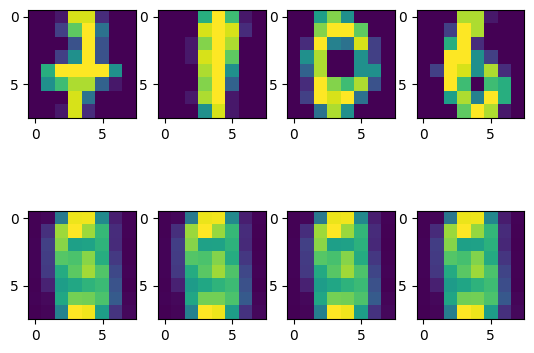

In [16]:
model.eval()
fig, axs = plt.subplots(2,4)
for x,_ in test_dl:
    with torch.no_grad():
        o = model(x).numpy()
    for i in range(4):
        axs[0][i].imshow(x[i][0])
        axs[1][i].imshow(o[i][0])
    break

In [17]:
class ConvDeconvAutoencoder(nn.Module):
    def __init__(self, latent=16,img_shape=(1,8,8)):
        super().__init__()
        
        s= 1
        for elem in img_shape:
            s *= elem
        
        self.encoder = nn.Sequential(
            nn.Conv2d(img_shape[0],8,3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(8,16,3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16,latent,3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Tanh()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent,32),
            nn.ReLU(inplace=True),
            Reshape((-1,8,2,2)),
            nn.ConvTranspose2d(8,4,2,stride=2),
            nn.BatchNorm2d(4),
            nn.ConvTranspose2d(4,1,2,stride=2),
            nn.Sigmoid()
        )
    
    def forward(self,x):
        enc = self.encoder(x)
        return self.decoder(enc)

In [18]:
model = ConvDeconvAutoencoder()
crit = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(),lr=0.4)

In [19]:
model.train()
for epoch in range(20):
    tot_loss = 0
    for x,_ in train_dl:
        optim.zero_grad()
        o = model(x)
        l = crit(o,x)
        tot_loss += l.item()
        l.backward()
        optim.step()
    print(tot_loss/len(train_dl))

0.11693826897276773
0.08090782430436876
0.0753696362177531
0.07171825733449724
0.0678335600429111
0.06452777609229088
0.06130226999521256
0.05810803497831027
0.05516054514381621
0.052563810348510744
0.049407448785172565
0.0475632449818982
0.045541377862294515
0.04397431686520577
0.04217694848775864
0.04092440182964007
0.039399978352917565
0.03857982183496157
0.03749852917260594
0.03672345446215736


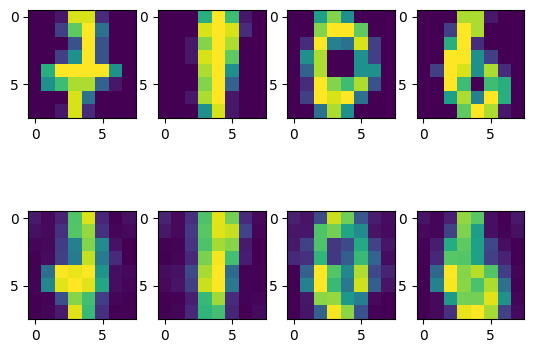

In [20]:
model.eval()
fig, axs = plt.subplots(2,4)
for x,_ in test_dl:
    with torch.no_grad():
        o = model(x).numpy()
    for i in range(4):
        axs[0][i].imshow(x[i][0])
        axs[1][i].imshow(o[i][0])
    break

# GAN: Linear and Deconvolution

In [21]:
latent = 16
model_generator = nn.Sequential(
    nn.Linear(latent,32),
    nn.ReLU(),
    nn.Linear(32,64),
    nn.Sigmoid(),
    Reshape((-1,1,8,8))
)

model_discriminator = nn.Sequential(
    nn.Conv2d(1,16,3,padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(16,32,3,padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(32,32,3,padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(32,1)
)

crit = nn.BCEWithLogitsLoss()
optim_generator = torch.optim.SGD(model_generator.parameters(),lr=0.2)
optim_discriminator = torch.optim.SGD(model_discriminator.parameters(),lr=0.02)

In [22]:
model_generator.train()
model_discriminator.train()
for epoch in range(10):
    tot_loss_discriminator = 0
    tot_loss_generator = 0
    for x,y in train_dl:
        optim_generator.zero_grad()
        optim_discriminator.zero_grad()
        
        N = len(x)
        real_labels = torch.ones((N,1))
        fake_labels = torch.zeros((N,1))
        
        noise = torch.randn((N,latent))
        fake_imgs = model_generator(noise).detach()
        loss_discriminator = 0.5 * (crit(model_discriminator(fake_imgs),fake_labels) + \
                            crit(model_discriminator(x),real_labels))
        
        noise = torch.randn((N,latent))
        fake_imgs = model_generator(noise)
        loss_generator = crit(model_discriminator(fake_imgs),real_labels)
        
        loss_discriminator.backward()
        loss_generator.backward()
        
        tot_loss_discriminator += loss_discriminator.item()
        tot_loss_generator += loss_generator.item()
        
        optim_generator.step()
        optim_discriminator.step()
    print(f"loss discriminattor: {tot_loss_discriminator / len(train_dl)}, loss generator: {tot_loss_generator / len(train_dl)}")

loss discriminattor: 0.7142076664500766, loss generator: 0.5084532658259074
loss discriminattor: 0.8007414009835985, loss generator: 0.3027902603149414
loss discriminattor: 0.8040701270103454, loss generator: 0.2932333297199673
loss discriminattor: 0.7973104039827983, loss generator: 0.2944141613112556
loss discriminattor: 0.7895499202940199, loss generator: 0.29772203233506944
loss discriminattor: 0.7809549185964796, loss generator: 0.3007182531886631
loss discriminattor: 0.7715680824385749, loss generator: 0.3046993136405945
loss discriminattor: 0.7603239019711813, loss generator: 0.3107602728737725
loss discriminattor: 0.7501960436503092, loss generator: 0.3158271504773034
loss discriminattor: 0.7365480621655782, loss generator: 0.3204266283247206


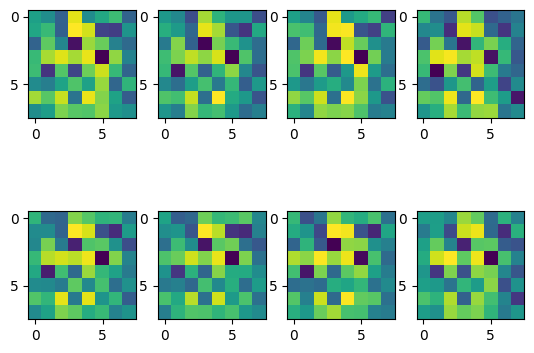

In [23]:
model_generator.eval()
fig, axs = plt.subplots(2,4)

noise = torch.randn((8,latent))
with torch.no_grad():
    o = model_generator(noise).numpy()
    
for i in range(8):
    axs[i//4, i%4].imshow(o[i][0])


In [24]:
tmp = nn.ConvTranspose2d(1,3,3)
tmp(torch.zeros((1,1,2,2))).shape

torch.Size([1, 3, 4, 4])

In [26]:
latent = 16
model_generator = nn.Sequential(
    nn.Linear(latent,64),
    nn.ReLU(inplace=True),
    Reshape((-1,64,1,1)),
    nn.ConvTranspose2d(64,16,2),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(16,8,3),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(8,1,5),
    nn.Sigmoid()
)

model_discriminator = nn.Sequential(
    nn.Conv2d(1,16,3,padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(16,32,3,padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(32,32,3,padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(32,1)
)

crit = nn.BCEWithLogitsLoss()
optim_generator = torch.optim.SGD(model_generator.parameters(),lr=0.1)
optim_discriminator = torch.optim.SGD(model_discriminator.parameters(),lr=0.001)

In [27]:
model_generator.train()
model_discriminator.train()
for epoch in range(10):
    tot_loss_discriminator = 0
    tot_loss_generator = 0
    for x,y in train_dl:
        optim_generator.zero_grad()
        optim_discriminator.zero_grad()
        
        N = len(x)
        real_labels = torch.ones((N,1))
        fake_labels = torch.zeros((N,1))
        
        noise = torch.randn((N,latent))
        fake_imgs = model_generator(noise).detach()
        loss_discriminator = 0.5 * (crit(model_discriminator(fake_imgs),fake_labels) + \
                            crit(model_discriminator(x),real_labels))
        loss_discriminator.backward()
        optim_discriminator.step()
        
        noise = torch.randn((N,latent))
        fake_imgs = model_generator(noise)
        loss_generator = crit(model_discriminator(fake_imgs),real_labels)
        loss_generator.backward()
        optim_generator.step()
        
        tot_loss_discriminator += loss_discriminator.item()
        tot_loss_generator += loss_generator.item()
        
    print(f"loss discriminattor: {tot_loss_discriminator / len(train_dl)}, loss generator: {tot_loss_generator / len(train_dl)}")

loss discriminattor: 0.6970635520087348, loss generator: 0.6815299378501044
loss discriminattor: 0.6963515705532498, loss generator: 0.6815130379464891
loss discriminattor: 0.6956544478734334, loss generator: 0.6814721372392443
loss discriminattor: 0.695079419347975, loss generator: 0.6812310722139147
loss discriminattor: 0.694575137562222, loss generator: 0.6809311310450236
loss discriminattor: 0.694052153163486, loss generator: 0.6806547959645589
loss discriminattor: 0.6935161047511631, loss generator: 0.6803969846831428
loss discriminattor: 0.6929594834645589, loss generator: 0.6801341189278497
loss discriminattor: 0.6923870325088501, loss generator: 0.6798461940553453
loss discriminattor: 0.6917971836196052, loss generator: 0.6795532200071547


tensor(-0.0669)


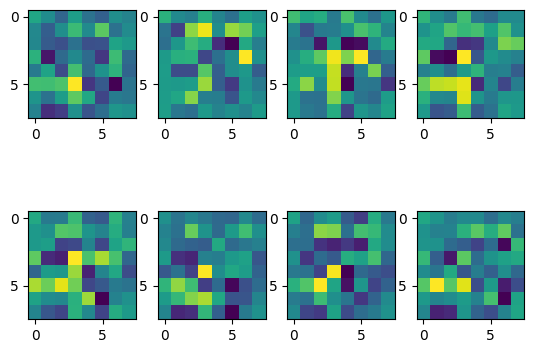

In [28]:
model_generator.eval()
fig, axs = plt.subplots(2,4)

noise = torch.randn((8,latent))
print(noise[0][0])
with torch.no_grad():
    o = model_generator(noise).numpy()
    
for i in range(8):
    axs[i//4, i%4].imshow(o[i][0])

